In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

In [2]:
def parser(record):
    img_features = tf.parse_single_example(
            record,
            features={ 'Label'    : tf.FixedLenFeature([], tf.int64),
                       'image_raw': tf.FixedLenFeature([], tf.string),
                       'height':tf.FixedLenFeature([],tf.int64),
                       'width':tf.FixedLenFeature([],tf.int64),
                       'channel':tf.FixedLenFeature([],tf.int64)})
    height = tf.cast(img_features['height'], tf.int64)
    width = tf.cast(img_features['width'], tf.int64)
    channel = tf.cast(img_features['channel'], tf.int64)
#     image_shape = tf.parallel_stack([height, width, channel])
    label = tf.cast(img_features['Label'], tf.int64)
    
    image = tf.decode_raw(img_features['image_raw'], tf.uint8)
    image = tf.reshape(image, [224,224,3])
#     image.set_shape([299,299,3])
    
    return image, label

In [3]:
def preprocess_for_train(image):
    image_data = tf.image.resize_images(image,[224,224],method=0)
    image_data = tf.image.random_saturation(image_data,lower=0.5,upper=1.5)
    image_data = tf.image.random_brightness(image_data,max_delta=70. /255.) #亮度
    image_data = tf.image.random_contrast(image_data,0.8,1.2)
    image_data = tf.image.random_flip_left_right(image_data)
    return image_data

In [4]:
batch_size = 16
train_files = tf.train.match_filenames_once("./data/Train2.tfrecords")
dataset = tf.data.TFRecordDataset(train_files)
dataset = dataset.map(parser)

test_files = tf.train.match_filenames_once("./data/Train2.tfrecords")
test_dataset = tf.data.TFRecordDataset(test_files)
test_dataset = test_dataset.map(parser)

dataset = dataset.map(
    lambda image,label:(
        preprocess_for_train(image),label))
dataset = dataset.shuffle(2000).batch(batch_size)

test_dataset = test_dataset.map(
    lambda image,label:(
        tf.image.resize_images(image,[224,224],method=0),label))
test_dataset = test_dataset.batch(64)

In [5]:
NUM_EPOCH = 130
dataset = dataset.repeat(NUM_EPOCH)
Label_size = 830

iterator = dataset.make_initializable_iterator()
image_batch,label_batch = iterator.get_next()

test_iterator = test_dataset.make_initializable_iterator()
test_image_batch,test_label_batch = test_iterator.get_next()

learning_rate = 0.0001

In [6]:
initializer = tf.contrib.layers.xavier_initializer()
def weight_variable(shape):
    return tf.Variable(initializer(shape))

def bias_variable(shape):
    return tf.Variable(initializer(shape))

def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding="SAME")

def max_pool(x):
    return tf.nn.max_pool(x,ksize=[1,4,4,1],strides=[1,4,4,1],padding="SAME")

x = tf.placeholder(tf.float32,[None,224,224,3],name='input_x')
y = tf.placeholder(tf.int32,[None],name="input_y")
image_labels = tf.one_hot(y,Label_size)

#conv1
W_conv1 = weight_variable([11,11,3,96])
b_conv1 = bias_variable([96])

h_conv1 = tf.nn.relu(tf.nn.conv2d(x,W_conv1,strides=[1,4,4,1],padding="VALID")+b_conv1)
h_pool1 = tf.nn.max_pool(h_conv1,ksize=[1,3,3,1],strides=[1,2,2,1],padding="SAME")

#conv2
W_conv2 = weight_variable([5,5,96,256])
b_conv2 = bias_variable([256])

h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1,W_conv2,strides=[1,1,1,1],padding="SAME")+b_conv2)
h_pool2 = tf.nn.max_pool(h_conv2,ksize=[1,3,3,1],strides=[1,2,2,1],padding="VALID")

#conv3~5
W_conv3 = weight_variable([3,3,256,384])
b_conv3 = bias_variable([384])
h_conv3 = tf.nn.relu(conv2d(h_pool2,W_conv3)+b_conv3)

W_conv4 = weight_variable([3,3,384,384])
b_conv4 = bias_variable([384])
h_conv4 = tf.nn.relu(conv2d(h_conv3,W_conv4)+b_conv4)

W_conv5 = weight_variable([3,3,384,256])
b_conv5 = bias_variable([256])
h_conv5 = tf.nn.relu(conv2d(h_conv4,W_conv5)+b_conv5)
h_pool5 = tf.nn.max_pool(h_conv5,ksize=[1,3,3,1],strides=[1,2,2,1],padding="VALID")

#扁平化
h_flat = tf.reshape(h_pool5,[-1,6*6*256])

#keep_prob 防過擬和
keep_prob = tf.placeholder(tf.float32,name='keep_prob')

W_fc1 = weight_variable([6*6*256,1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_flat,W_fc1)+b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1,keep_prob)

#FC2
W_fc2 = weight_variable([1024,1024])
b_fc2 = bias_variable([1024])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop,W_fc2)+b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2,keep_prob)

#FC3 
W_fc3 = weight_variable([1024,Label_size])
b_fc3 = bias_variable([Label_size])

#輸出
logits = tf.matmul(h_fc2_drop,W_fc3)+b_fc3
logits = tf.identity(logits, name='logits')

with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=image_labels,logits=logits))
    tf.summary.scalar('loss',loss)
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):  
        prediction = tf.argmax(logits,1,name="prediction")
        correct_prediction = tf.equal(tf.argmax(logits,1),tf.argmax(image_labels,1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32),name='accuracy')
        tf.summary.scalar('accuracy',accuracy)

tf.add_to_collection('pred_network', prediction)
merged = tf.summary.merge_all()

In [7]:
logs_dir = str(int(time.time()))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    sess.run(iterator.initializer)
    save_model_path = 'logs/'+logs_dir+'/model/TransferModel'
    train_writer = tf.summary.FileWriter('logs/'+logs_dir+'/train',sess.graph)
    test_writer = tf.summary.FileWriter('logs/'+logs_dir+'/test',sess.graph)
    dropout = 0.5
    
    count = 0
    train_t_acc = []
    train_t_loss = []
    test_t_acc = []
    test_t_loss = []
    train_acc = []
    train_loss = []
    while True:
        try:
            image,label = sess.run([image_batch,label_batch])
            _,train_acctemp,train_losstemp,summary = sess.run([train_step,accuracy,loss,merged], feed_dict={x: image, y: label,keep_prob:dropout})
            train_acc.append(train_acctemp)
            train_loss.append(train_losstemp)
            train_writer.add_summary(summary,count)
            if count % 100 == 0:
                sess.run(test_iterator.initializer)
                test_acc = []
                test_loss = []
                while True:
                    try:
                        test_image,test_label = sess.run([test_image_batch,test_label_batch])
                        test_acctemp,test_losstemp = sess.run([accuracy,loss],feed_dict={x: test_image,y:test_label,keep_prob:1})
                        test_acc.append(test_acctemp)
                        test_loss.append(test_losstemp)
                    except:
                        train_p_acc = np.mean(train_acc)
                        train_p_loss = np.mean(train_loss) 
                        test_p_acc = np.mean(test_acc)
                        test_p_loss = np.mean(test_loss)
                        test_summary = tf.Summary()
                        test_summary.value.add(tag="loss/loss", simple_value=test_p_loss)
                        test_summary.value.add(tag="evaluation/accuracy/accuracy",simple_value=test_p_acc)
                        test_writer.add_summary(test_summary,count)
                        print('Iter %d,train_acc %f train_loss %f test_acc %f test_loss %f' % (count,train_p_acc,train_p_loss,test_p_acc,test_p_loss))
                        train_t_acc.append(train_p_acc)
                        train_t_loss.append(train_p_loss)
                        test_t_acc.append(test_p_acc)
                        test_t_loss.append(test_p_loss)
                        train_acc = []
                        train_loss = []
                        break
            count+=1
        except :
            
            saver = tf.train.Saver()
            save_path = saver.save(sess, save_model_path)
            print("Done")
            break

Iter 0,train_acc 0.000000 train_loss 28.136765 test_acc 0.001488 test_loss 9.847521
Iter 100,train_acc 0.001875 train_loss 7.050983 test_acc 0.000000 test_loss 6.718666
Iter 200,train_acc 0.000625 train_loss 6.732460 test_acc 0.000744 test_loss 6.711601
Iter 300,train_acc 0.001875 train_loss 6.736361 test_acc 0.001488 test_loss 6.706059
Iter 400,train_acc 0.001250 train_loss 6.722078 test_acc 0.001488 test_loss 6.707563
Iter 500,train_acc 0.000000 train_loss 6.714460 test_acc 0.002232 test_loss 6.696149
Iter 600,train_acc 0.001250 train_loss 6.713542 test_acc 0.001488 test_loss 6.687956
Iter 700,train_acc 0.001875 train_loss 6.711262 test_acc 0.001488 test_loss 6.686282
Iter 800,train_acc 0.000625 train_loss 6.700632 test_acc 0.003720 test_loss 6.689548
Iter 900,train_acc 0.002500 train_loss 6.697876 test_acc 0.001488 test_loss 6.680763
Iter 1000,train_acc 0.001250 train_loss 6.691684 test_acc 0.002165 test_loss 6.651079
Iter 1100,train_acc 0.000625 train_loss 6.693547 test_acc 0.00297

Iter 9600,train_acc 0.898333 train_loss 0.383314 test_acc 1.000000 test_loss 0.003697
Iter 9700,train_acc 0.902500 train_loss 0.394835 test_acc 0.999256 test_loss 0.007574
Iter 9800,train_acc 0.882917 train_loss 0.388517 test_acc 0.999256 test_loss 0.006606
Iter 9900,train_acc 0.906250 train_loss 0.355930 test_acc 0.998512 test_loss 0.006686
Iter 10000,train_acc 0.915000 train_loss 0.337235 test_acc 0.999256 test_loss 0.009224
Iter 10100,train_acc 0.916875 train_loss 0.304832 test_acc 1.000000 test_loss 0.003142
Iter 10200,train_acc 0.906667 train_loss 0.345224 test_acc 0.999256 test_loss 0.005731
Iter 10300,train_acc 0.925625 train_loss 0.263480 test_acc 1.000000 test_loss 0.001540
Iter 10400,train_acc 0.918125 train_loss 0.315381 test_acc 1.000000 test_loss 0.002859
Iter 10500,train_acc 0.922708 train_loss 0.300024 test_acc 1.000000 test_loss 0.002015
Iter 10600,train_acc 0.912500 train_loss 0.318699 test_acc 1.000000 test_loss 0.001633
Done


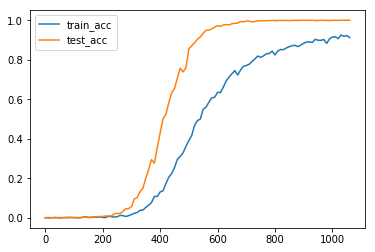

In [8]:
%matplotlib inline
x = np.arange(0, 107, 1)

 
plt.plot(x*10, train_t_acc, label="train_acc")
plt.plot(x*10, test_t_acc, label="test_acc")
 
plt.legend(loc=0, ncol=1) 
 
plt.show()

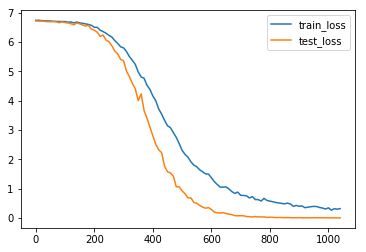

In [9]:
%matplotlib inline
x = np.arange(0, 105, 1)

train_t_loss = train_t_loss[2:]
test_t_loss = test_t_loss[2:]
 
plt.plot(x*10, train_t_loss, label="train_loss")
plt.plot(x*10, test_t_loss, label="test_loss")
 
plt.legend(loc=0, ncol=1) 
 
plt.show()